In [2]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
import gym
import numpy as np
import random as rand

class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1
        
        self.node_num = 12
        self.learning_rate = 0.002
        self.epochs_cnt = 1
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()
        
        self.discount_rate = 0.95
        self.penalty = -100

        self.episode_num = 500
        
        self.moving_avg_size = 20
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
        self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE = np.zeros((1,self.action_size)), np.zeros((1,self.value_size))
 
    class MyModel(tf.keras.Model):
        def train_step(self, data):

            in_datas, out_action_probs = data
            states, action_matrixs, advantages = in_datas[0], in_datas[1], in_datas[2]

            with tf.GradientTape() as tape:
                y_pred = self(states, training=True)  # Forward pass
                action_probs = K.max(action_matrixs*y_pred, axis=-1)
                loss = -K.log(action_probs)*advantages

            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            
    def build_model_actor(self):
        input_states = Input(shape=(self.state_size), name='input_states')
        input_action_matrixs = Input(shape=(self.action_size), name='input_action_matrixs')
        input_advantages = Input(shape=(self.value_size), name='input_advantages')
        
        x = (input_states)
        x = Dense(self.node_num, activation='relu')(x)
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)
        
        model = self.MyModel(inputs=[input_states, input_action_matrixs, input_advantages], outputs=out_actions)
        model.compile(optimizer=Adam(lr=self.learning_rate))
        
        model.summary()
        return model
    
    def build_model_critic(self):
        input_states = Input(shape=(self.state_size), name='input_states')
        
        x = (input_states)
        x = Dense(self.node_num, activation='relu')(x)
        out_values = Dense(self.value_size, activation='linear', name='output')(x)
        
        model = tf.keras.models.Model(inputs=[input_states], outputs=[out_values])
        model.compile(optimizer=Adam(lr=self.learning_rate),
                      loss='mean_squared_error'
                     )
        model.summary()
        return model

    def train(self):
        reward_list=[]
        count_list = []
        moving_avg_list = []
        for episode in range(self.episode_num):

            state = self.env.reset()
            self.env.max_episode_steps = 500
            count, reward_tot = self.make_memory(episode, state)
            
            if count < 500:
                reward_tot = reward_tot-self.penalty
                
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
            
            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))

        self.save_model()
        
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        while not done:
            count+=1

            state_t = np.reshape(state, [1,self.state_size]) #현재상태
            action_matrix_t = np.reshape(action_matrix, [1,self.action_size])
            
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE])
            action = np.random.choice(self.action_size, 1, p=action_prob[0])[0]
            
            action_matrix = np.zeros(self.action_size) #초기화
            action_matrix[action] = 1

            state_next, reward, done, none = self.env.step(action)
            
            if count < 500 and done:
                reward = self.penalty 
    
            self.train_mini_batch(state, state_next, reward, action_matrix, action_prob, done, count)
    
            state = state_next
                
            reward_tot += reward
            
        return count, reward_tot
    
    def train_mini_batch(self, state, state_next, reward, action_matrix, action_prob, done, count):
        
        state_t = np.reshape(state, [1, self.state_size])
        state_next_t = np.reshape(state_next, [1, self.state_size])
        reward_t = np.reshape(reward, [1, self.value_size])
        action_matrix_t = np.reshape(action_matrix, [1, self.action_size])
        action_prob_t = np.reshape(action_prob, [1, self.action_size])
        
        advantage_t = np.zeros((1, self.value_size))
        target_t = np.zeros((1, self.value_size))        
        
        value_t = self.model_critic.predict(state_t)
        value_next_t = self.model_critic.predict(state_next_t)
        
        if(count< 500 and done):
            advantage_t =  reward_t - value_t
            target_t = reward_t
        else:
            advantage_t = reward_t + self.discount_rate*value_next_t - value_t
            target_t = reward_t + self.discount_rate * value_next_t

        self.model_actor.fit(x=[state_t, action_matrix_t, advantage_t], y=[action_prob_t], epochs=self.epochs_cnt, verbose=0)
        self.model_critic.fit(x=state_t, y=target_t, epochs=self.epochs_cnt, verbose=0)  

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def save_model(self):
        self.model_actor.save("./model/a2c")
        print("*****end a2c learing")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "my_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_states (InputLayer)       [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           60          input_states[0][0]               
__________________________________________________________________________________________________
input_action_matrixs (InputLaye [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_advantages (InputLayer)   [(None, 1)]          0                                            
_________________________________________________________________________________________

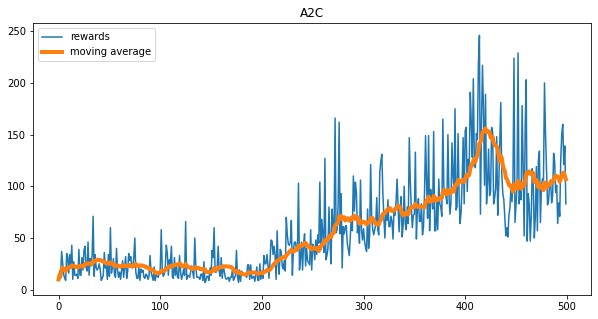

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('A2C')
plt.show()